# Agrupación y Segmentación de Vecindarios en la Ciudad de Toronto, Canadá

### Importar librerías

In [302]:
import numpy as np # librería para manejar datos vectorizados

import pandas as pd # librería para análisis de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # librería para manejar archivos JSON 

!conda install -c conda-forge geopy --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas

# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

print('Libraries imported.')

Libraries imported.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare


In [303]:
df = pd.read_excel(r'C:\Users\sergio.carmona\Documents\Certificados Curso DataScience\Videos Curso DataScience\Curso 9. Capstone\Data1.xlsx')
df.head()

,Contenido
0,M1ANot assigned
1,M1BScarborough(Malvern / Rouge)
2,M1CScarborough(Rouge Hill / Port Union / Highl...
3,M1EScarborough(Guildwood / Morningside / West ...
4,M1GScarborough(Woburn)


### Parte 1. Armar DataFrame

In [304]:
#Extraer PostalCode
df['Postal Code'] = df['Contenido'].str.extract('(\w{1}\d{1}\w{1})')

In [305]:
#Extraer Borough
df['Borough'] = df['Contenido'].str.extract('(?<=\w{1}\d{1}\w{1})(.*)(?=\()')

In [306]:
df['Temp'] = df['Contenido'].str.extract('(?<=\()(.*)(?=\))')

In [307]:
#Extraer Neighborhood
df['Neighborhood'] = df['Temp'].str.split(' / ')

In [308]:
#Eliminar columnas innecesarias
df = df.drop('Contenido',1).drop('Temp',1)

In [309]:
#Eliminar filas Nan
df = df.dropna()

In [310]:
df = df.reset_index(drop=True)

In [311]:
df.shape

(103, 3)

In [312]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"[Malvern, Rouge]"
1,M1C,Scarborough,"[Rouge Hill, Port Union, Highland Creek]"
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]"
3,M1G,Scarborough,[Woburn]
4,M1H,Scarborough,[Cedarbrae]


### Cargar archivo de coordenadas

In [313]:
#Leer archivo CSV de coordenadas
df_coordenadas = pd.read_csv(r'C:\Users\sergio.carmona\Documents\Certificados Curso DataScience\Videos Curso DataScience\Curso 9. Capstone\Geospatial_Coordinates.csv')
df_coordenadas.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [314]:
#Combinar mi DataFrame con la tabla de coordenadas
df = pd.merge(df, df_coordenadas)

In [315]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"[Malvern, Rouge]",43.806686,-79.194353
1,M1C,Scarborough,"[Rouge Hill, Port Union, Highland Creek]",43.784535,-79.160497
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]",43.763573,-79.188711
3,M1G,Scarborough,[Woburn],43.770992,-79.216917
4,M1H,Scarborough,[Cedarbrae],43.773136,-79.239476


In [316]:
#Trabajar solo con los vecindarios de Toronto
df = df[df.Borough.str.contains('Toronto')].reset_index(drop=True)

In [317]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,[The Beaches],43.676357,-79.293031
1,M4J,East YorkEast Toronto,[The Danforth East],43.685347,-79.338106
2,M4K,East Toronto,"[The Danforth West, Riverdale]",43.679557,-79.352188
3,M4L,East Toronto,"[India Bazaar, The Beaches West]",43.668999,-79.315572
4,M4M,East Toronto,[Studio District],43.659526,-79.340923


### Determinar coordenadas de la ciudad de Toronto

In [318]:
adress = 'Toronto'

geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(adress)
latitude = location.latitude
longitude = location.longitude
print('las coordenadas de ', adress, 'son {}, {}'.format(latitude, longitude) )

las coordenadas de  Toronto son 43.6534817, -79.3839347


### Generar mapa de Toronto

In [319]:
#Crear un mapa de New York
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

#Añadir marcadores al mapa
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
    
map_toronto

### Definir la versión y credenciales de FourSquare

In [320]:
CLIENT_ID = 'WKI0W2LBI2UMLVCXTZ3WA5JG13K0Z0UGCPKBZYS0RGCTNEA0' # su ID de Foursquare
CLIENT_SECRET = 'GS2FBGTB4Y4UILB43VDDVINRGZ1YM2VUMJ2MB0VX2WSDPSPZ' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WKI0W2LBI2UMLVCXTZ3WA5JG13K0Z0UGCPKBZYS0RGCTNEA0
CLIENT_SECRET:GS2FBGTB4Y4UILB43VDDVINRGZ1YM2VUMJ2MB0VX2WSDPSPZ


### Explorar el primer barrio del DataFrame

In [321]:
#Obtener el nombre
df.loc[0, 'Neighborhood']

['The Beaches']

In [322]:
#Obtener coordenadas
neighborhood_latitude = df.loc[0, 'Latitude']
neighborhood_longitude = df.loc[0, 'Longitude']
neighborhood_name = df.loc[0, 'Neighborhood']

In [323]:
print("las coordenadas del barrio {}, son {}, {}".format(neighborhood_name,
                                                         neighborhood_latitude,
                                                         neighborhood_longitude
                                                        ))

las coordenadas del barrio ['The Beaches'], son 43.67635739999999, -79.2930312


# Obtengamos los 100 sitios en The Beaches en un radio de 500 metros

In [324]:
radius = 500
limit = 100
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}".format(CLIENT_ID,
                                                                                                                        CLIENT_SECRET,
                                                                                                                        VERSION,
                                                                                                                        neighborhood_latitude,
                                                                                                                        neighborhood_longitude,
                                                                                                                        limit,
                                                                                                                        radius)
url

'https://api.foursquare.com/v2/venues/explore?client_id=WKI0W2LBI2UMLVCXTZ3WA5JG13K0Z0UGCPKBZYS0RGCTNEA0&client_secret=GS2FBGTB4Y4UILB43VDDVINRGZ1YM2VUMJ2MB0VX2WSDPSPZ&v=20180605&ll=43.67635739999999,-79.2930312&limit=100&radius=500'

Enviar la solicitud para examinar los resultados

In [325]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a82adb801445385c5d66bd'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

Del laboratorio anterior de FourSquare sabemos que toda la información esta en la llave items. Antes de avanzar, usemos la función get_category_type del laboratorio anterios.

In [326]:
# función para extraer la categoria del sitio
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Ahora estamos listos para limpiar el objeto json y estructurarlo en un dataframe pandas.

In [327]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # objeto JSON

# filtrar columnas
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filtrar la categoría para cada fila
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# limpiar columnas
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-327-1c6db9e35c87>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # objeto JSON


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [328]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


# Explorar Barrios de Toronto

In [329]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [330]:
url

'https://api.foursquare.com/v2/venues/explore?client_id=WKI0W2LBI2UMLVCXTZ3WA5JG13K0Z0UGCPKBZYS0RGCTNEA0&client_secret=GS2FBGTB4Y4UILB43VDDVINRGZ1YM2VUMJ2MB0VX2WSDPSPZ&v=20180605&ll=43.67635739999999,-79.2930312&limit=100&radius=500'

### Ahora escriba el código para ejecutar la función anterior en cada vecindario y crear un nuevo dataframe llamado toronto venues.

In [331]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

['The Beaches']
['The Danforth East']
['The Danforth West', 'Riverdale']
['India Bazaar', 'The Beaches West']
['Studio District']
['Lawrence Park']
['Davisville North']
['North Toronto West']
['Davisville']
['Moore Park', 'Summerhill East']
['Summerhill West', 'Rathnelly', 'South Hill', 'Forest Hill SE', 'Deer Park']
['Rosedale']
['St. James Town', 'Cabbagetown']
['Church and Wellesley']
['Regent Park', 'Harbourfront']
['Garden District, Ryerson']
['St. James Town']
['Berczy Park']
['Central Bay Street']
['Richmond', 'Adelaide', 'King']
['Harbourfront East', 'Union Station', 'Toronto Islands']
['Toronto Dominion Centre', 'Design Exchange']
['Commerce Court', 'Victoria Hotel']
['Roselawn']
['Forest Hill North & West']
['The Annex', 'North Midtown', 'Yorkville']
['University of Toronto', 'Harbord']
['Kensington Market', 'Chinatown', 'Grange Park']
['CN Tower', 'King and Spadina', 'Railway Lands', 'Harbourfront West', 'Bathurst Quay', 'South Niagara', 'Island airport']
['Enclave of M5E']


In [332]:
# Revisemos el tamaño del dataframe resultante
print(toronto_venues.shape)
toronto_venues.head()

(1583, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,[The Beaches],43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,[The Beaches],43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,[The Beaches],43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,[The Beaches],43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,[The Danforth East],43.685347,-79.338106,Aldwych Park,43.684901,-79.341091,Park


Encontremos cuantas categorías únicas se pueden conservar de todos los sitios regresados

In [333]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


# Analizar cada barrio

In [334]:
# codificación
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']])

# añadir la columna de barrio de regreso al dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Stadium,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Butcher,Venue Category_Café,Venue Category_Cajun / Creole Restaurant,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Climbing Gym,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Coworking Space,Venue Category_Creperie,Venue Category_Cuban Restaurant,Venue Category_Cupcake Shop,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Harbor / Marina,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospital,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restaur

In [335]:
toronto_onehot.shape

(1583, 235)

In [336]:
toronto_onehot['liststring'] = [','.join(map(str, l)) for l in toronto_onehot['Neighborhood']]

In [337]:
toronto_onehot.head()

,Neighborhood,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Stadium,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Butcher,Venue Category_Café,Venue Category_Cajun / Creole Restaurant,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Climbing Gym,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Coworking Space,Venue Category_Creperie,Venue Category_Cuban Restaurant,Venue Category_Cupcake Shop,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Harbor / Marina,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospital,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restaur

Agrupemos las filas por barrios tomando la média de la frecuancia de la ocurrencia de cada categoría

In [346]:
toronto_grouped = toronto_onehot.groupby('liststring').mean().reset_index()
toronto_grouped.head()

,liststring,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Stadium,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Butcher,Venue Category_Café,Venue Category_Cajun / Creole Restaurant,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Climbing Gym,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Coworking Space,Venue Category_Creperie,Venue Category_Cuban Restaurant,Venue Category_Cupcake Shop,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Harbor / Marina,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospital,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restauran

In [347]:
toronto_grouped.head()

,liststring,Venue Category_Adult Boutique,Venue Category_Airport,Venue Category_Airport Food Court,Venue Category_Airport Gate,Venue Category_Airport Lounge,Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Aquarium,Venue Category_Art Gallery,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Auto Workshop,Venue Category_BBQ Joint,Venue Category_Baby Store,Venue Category_Bagel Shop,Venue Category_Bakery,Venue Category_Bank,Venue Category_Bar,Venue Category_Baseball Stadium,Venue Category_Basketball Stadium,Venue Category_Beach,Venue Category_Bed & Breakfast,Venue Category_Beer Bar,Venue Category_Beer Store,Venue Category_Belgian Restaurant,Venue Category_Bistro,Venue Category_Boat or Ferry,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Brazilian Restaurant,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Bubble Tea Shop,Venue Category_Burger Joint,Venue Category_Burrito Place,Venue Category_Bus Line,Venue Category_Butcher,Venue Category_Café,Venue Category_Cajun / Creole Restaurant,Venue Category_Camera Store,Venue Category_Candy Store,Venue Category_Caribbean Restaurant,Venue Category_Cheese Shop,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Church,Venue Category_Climbing Gym,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_College Arts Building,Venue Category_College Gym,Venue Category_College Rec Center,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Comic Shop,Venue Category_Concert Hall,Venue Category_Construction & Landscaping,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Coworking Space,Venue Category_Creperie,Venue Category_Cuban Restaurant,Venue Category_Cupcake Shop,Venue Category_Dance Studio,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Dumpling Restaurant,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Escape Room,Venue Category_Ethiopian Restaurant,Venue Category_Event Space,Venue Category_Falafel Restaurant,Venue Category_Farmers Market,Venue Category_Fast Food Restaurant,Venue Category_Filipino Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Fish Market,Venue Category_Flea Market,Venue Category_Flower Shop,Venue Category_Food,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_Fountain,Venue Category_French Restaurant,Venue Category_Fried Chicken Joint,Venue Category_Frozen Yogurt Shop,Venue Category_Fruit & Vegetable Store,Venue Category_Furniture / Home Store,Venue Category_Gaming Cafe,Venue Category_Garden,Venue Category_Garden Center,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gay Bar,Venue Category_General Entertainment,Venue Category_General Travel,Venue Category_German Restaurant,Venue Category_Gift Shop,Venue Category_Gluten-free Restaurant,Venue Category_Gourmet Shop,Venue Category_Greek Restaurant,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Harbor / Marina,Venue Category_Health & Beauty Service,Venue Category_Health Food Store,Venue Category_Historic Site,Venue Category_History Museum,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hospital,Venue Category_Hostel,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Intersection,Venue Category_Irish Pub,Venue Category_Italian Restaurant,Venue Category_Japanese Restauran

In [348]:
toronto_grouped.rename(columns = {'liststring':'Neighborhood'}, inplace = True)

# Imprimir cada barrio junto con los 5 sitios mas comunes

In [349]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print('----',hood,'----')
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Berczy Park ----
                           venue  freq
0     Venue Category_Coffee Shop  0.10
1    Venue Category_Cocktail Bar  0.07
2          Venue Category_Bakery  0.05
3        Venue Category_Pharmacy  0.03
4  Venue Category_Farmers Market  0.03


---- Brockton,Parkdale Village,Exhibition Place ----
                           venue  freq
0            Venue Category_Café  0.12
1          Venue Category_Bakery  0.08
2  Venue Category_Breakfast Spot  0.08
3       Venue Category_Nightclub  0.08
4     Venue Category_Coffee Shop  0.08


---- CN Tower,King and Spadina,Railway Lands,Harbourfront West,Bathurst Quay,South Niagara,Island airport ----
                                venue  freq
0      Venue Category_Airport Service  0.12
1     Venue Category_Airport Terminal  0.12
2      Venue Category_Harbor / Marina  0.06
3              Venue Category_Airport  0.06
4  Venue Category_Rental Car Location  0.06


---- Central Bay Street ----
                               venue  freq
0   

### **Pongamos eso en el dataframe**

Primero escribamos una función para ordenar los sitios en orden descendente.

In [350]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Generemos el nuevo dataframe y mostremos los primeros 10 sitios de cada barrio.

In [351]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Venue Category_Coffee Shop,Venue Category_Cocktail Bar,Venue Category_Bakery,Venue Category_Seafood Restaurant,Venue Category_Farmers Market,Venue Category_Cheese Shop,Venue Category_Pharmacy,Venue Category_Beer Bar,Venue Category_Restaurant,Venue Category_Shopping Mall
1,"Brockton,Parkdale Village,Exhibition Place",Venue Category_Café,Venue Category_Bakery,Venue Category_Breakfast Spot,Venue Category_Nightclub,Venue Category_Coffee Shop,Venue Category_Furniture / Home Store,Venue Category_Convenience Store,Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Stadium
2,"CN Tower,King and Spadina,Railway Lands,Harbou...",Venue Category_Airport Service,Venue Category_Airport Terminal,Venue Category_Sculpture Garden,Venue Category_Harbor / Marina,Venue Category_Plane,Venue Category_Coffee Shop,Venue Category_Boutique,Venue Category_Rental Car Location,Venue Category_Bar,Venue Category_Boat or Ferry
3,Central Bay Street,Venue Category_Coffee Shop,Venue Category_Italian Restaurant,Venue Category_Café,Venue Category_Sandwich Place,Venue Category_Japanese Restaurant,Venue Category_Salad Place,Venue Category_Burger Joint,Venue Category_Bubble Tea Shop,Venue Category_Pizza Place,Venue Category_Poke Place
4,Christie,Venue Category_Grocery Store,Venue Category_Café,Venue Category_Park,Venue Category_Coffee Shop,Venue Category_Baby Store,Venue Category_Bank,Venue Category_Candy Store,Venue Category_Italian Restaurant,Venue Category_Restaurant,Venue Category_Nightclub


In [352]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# **4. Barrios Agrupados**

Ejecutemos k-means para agrupar los barrios en 5 agrupaciones.

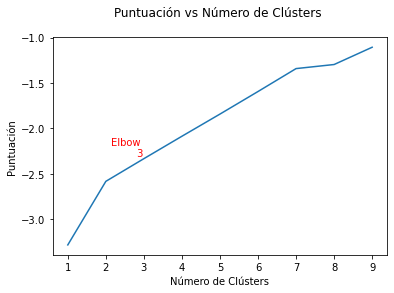

In [353]:
import matplotlib.pyplot as plt
Nc = range(1, 10)

dt_elbow=pd.DataFrame()

for i in Nc:
    kmeans = KMeans(init = "k-means++", n_clusters = i, n_init = 12)
    score = kmeans.fit(toronto_grouped_clustering).score(toronto_grouped_clustering)

    dt_elbow.loc[i, 0] = i
    dt_elbow.loc[i, 1] = score
    
dt_elbow.rename(columns={0: 'k', 1: 'score'}, inplace=True) #Reemplacemos los nombres de las columnas
   
#Plot the Elbow curve
plt.plot(dt_elbow['k'],dt_elbow['score'])

for i, row in dt_elbow.iterrows():
    if i == 3:
        plt.text(i, row['score'], str('Elbow \n {}'.format(i)), ha='right', va='bottom', color='red')
    

plt.xlabel('Número de Clústers')
plt.ylabel('Puntuación')
plt.title('Puntuación vs Número de Clústers \n')
#plt.savefig('../Images/Result2/img09_curvaelbow.png')
plt.show()

In [354]:
# establecer el número de agrupaciones
kclusters = 2

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Generemos un nuevo dataframe que incluya la agrupación asi como los 10 sitios mas populares de cada barrio.

In [355]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [356]:
df['liststring'] = [','.join(map(str, l)) for l in df['Neighborhood']]

In [357]:
df = df.drop('Neighborhood',1)

In [358]:
df.rename(columns = {'liststring':'Neighborhood'}, inplace = True)
df.head()

,Postal Code,Borough,Latitude,Longitude,Neighborhood
0,M4E,East Toronto,43.676357,-79.293031,The Beaches
1,M4J,East YorkEast Toronto,43.685347,-79.338106,The Danforth East
2,M4K,East Toronto,43.679557,-79.352188,"The Danforth West,Riverdale"
3,M4L,East Toronto,43.668999,-79.315572,"India Bazaar,The Beaches West"
4,M4M,East Toronto,43.659526,-79.340923,Studio District


In [359]:
toronto_merged = df

# juntar manhattan_grouped con manhattan_data 
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # revisar las ultimas columnas

,Postal Code,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,43.676357,-79.293031,The Beaches,1,Venue Category_Neighborhood,Venue Category_Health Food Store,Venue Category_Trail,Venue Category_Pub,Venue Category_Yoga Studio,Venue Category_Dumpling Restaurant,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Electronics Store
1,M4J,East YorkEast Toronto,43.685347,-79.338106,The Danforth East,0,Venue Category_Park,Venue Category_Convenience Store,Venue Category_Yoga Studio,Venue Category_Distribution Center,Venue Category_Farmers Market,Venue Category_Falafel Restaurant,Venue Category_Event Space,Venue Category_Ethiopian Restaurant,Venue Category_Escape Room,Venue Category_Electronics Store
2,M4K,East Toronto,43.679557,-79.352188,"The Danforth West,Riverdale",1,Venue Category_Greek Restaurant,Venue Category_Coffee Shop,Venue Category_Italian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Furniture / Home Store,Venue Category_Bubble Tea Shop,Venue Category_Indian Restaurant,Venue Category_Spa,Venue Category_Cosmetics Shop,Venue Category_Juice Bar
3,M4L,East Toronto,43.668999,-79.315572,"India Bazaar,The Beaches West",1,Venue Category_Fast Food Restaurant,Venue Category_Food & Drink Shop,Venue Category_Movie Theater,Venue Category_Sandwich Place,Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Steakhouse,Venue Category_Ice Cream Shop,Venue Category_Liquor Store
4,M4M,East Toronto,43.659526,-79.340923,Studio District,1,Venue Category_Coffee Shop,Venue Category_American Restaurant,Venue Category_Bakery,Venue Category_Brewery,Venue Category_Café,Venue Category_Gastropub,Venue Category_Yoga Studio,Venue Category_Food,Venue Category_Park,Venue Category_Neighborhood


Finalmente visualizar agrupaciones restantes

In [362]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [363]:
# Agrupacion 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East YorkEast Toronto,0,Venue Category_Park,Venue Category_Convenience Store,Venue Category_Yoga Studio,Venue Category_Distribution Center,Venue Category_Farmers Market,Venue Category_Falafel Restaurant,Venue Category_Event Space,Venue Category_Ethiopian Restaurant,Venue Category_Escape Room,Venue Category_Electronics Store
5,Central Toronto,0,Venue Category_Construction & Landscaping,Venue Category_Park,Venue Category_Bus Line,Venue Category_Swim School,Venue Category_Yoga Studio,Venue Category_Distribution Center,Venue Category_Falafel Restaurant,Venue Category_Event Space,Venue Category_Ethiopian Restaurant,Venue Category_Escape Room
9,Central Toronto,0,Venue Category_Restaurant,Venue Category_Park,Venue Category_Summer Camp,Venue Category_Trail,Venue Category_Donut Shop,Venue Category_Discount Store,Venue Category_Distribution Center,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Yoga Studio
11,Downtown Toronto,0,Venue Category_Park,Venue Category_Playground,Venue Category_Trail,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Event Space,Venue Category_Ethiopian Restaurant,Venue Category_Escape Room,Venue Category_Electronics Store,Venue Category_Eastern European Restaurant


In [364]:
# Agrupacion 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Venue Category_Neighborhood,Venue Category_Health Food Store,Venue Category_Trail,Venue Category_Pub,Venue Category_Yoga Studio,Venue Category_Dumpling Restaurant,Venue Category_Dog Run,Venue Category_Doner Restaurant,Venue Category_Donut Shop,Venue Category_Electronics Store
2,East Toronto,1,Venue Category_Greek Restaurant,Venue Category_Coffee Shop,Venue Category_Italian Restaurant,Venue Category_Ice Cream Shop,Venue Category_Furniture / Home Store,Venue Category_Bubble Tea Shop,Venue Category_Indian Restaurant,Venue Category_Spa,Venue Category_Cosmetics Shop,Venue Category_Juice Bar
3,East Toronto,1,Venue Category_Fast Food Restaurant,Venue Category_Food & Drink Shop,Venue Category_Movie Theater,Venue Category_Sandwich Place,Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Steakhouse,Venue Category_Ice Cream Shop,Venue Category_Liquor Store
4,East Toronto,1,Venue Category_Coffee Shop,Venue Category_American Restaurant,Venue Category_Bakery,Venue Category_Brewery,Venue Category_Café,Venue Category_Gastropub,Venue Category_Yoga Studio,Venue Category_Food,Venue Category_Park,Venue Category_Neighborhood
6,Central Toronto,1,Venue Category_Gym / Fitness Center,Venue Category_Breakfast Spot,Venue Category_Hotel,Venue Category_Food & Drink Shop,Venue Category_Department Store,Venue Category_Park,Venue Category_Playground,Venue Category_Sandwich Place,Venue Category_Pizza Place,Venue Category_Antique Shop
7,Central Toronto,1,Venue Category_Clothing Store,Venue Category_Coffee Shop,Venue Category_Yoga Studio,Venue Category_Ice Cream Shop,Venue Category_Salon / Barbershop,Venue Category_Restaurant,Venue Category_Rental Car Location,Venue Category_Park,Venue Category_Mexican Restaurant,Venue Category_Gift Shop
8,Central Toronto,1,Venue Category_Pizza Place,Venue Category_Dessert Shop,Venue Category_Sandwich Place,Venue Category_Coffee Shop,Venue Category_Sushi Restaurant,Venue Category_Gym,Venue Category_Café,Venue Category_Italian Restaurant,Venue Category_Park,Venue Category_Pharmacy
10,Central Toronto,1,Venue Category_Coffee Shop,Venue Category_Sushi Restaurant,Venue Category_American Restaurant,Venue Category_Supermarket,Venue Category_Light Rail Station,Venue Category_Fried Chicken Joint,Venue Category_Pub,Venue Category_Restaurant,Venue Category_Bank,Venue Category_Bagel Shop
12,Downtown Toronto,1,Venue Category_Coffee Shop,Venue Category_Park,Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Bakery,Venue Category_Pizza Place,Venue Category_Café,Venue Category_Pub,Venue Category_Caribbean Restaurant,Venue Category_Indian Restaurant
13,Downtown Toronto,1,Venue Category_Coffee Shop,Venue Category_Japanese Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Gay Bar,Venue Category_Pub,Venue Category_Men's Store,Venue Category_Mediterranean Restaurant,Venue Category_Hotel,Venue Category_Dance Studio
